## Plant image classification

**Objective** : This notebook's main focus will be on how to use CNN and Keras to classify images of an ornamental plant. We want to know the following things in particular.

- How accurately does CNN classify images?
- Which the best model/architecture for the classification?

### Import Libraries

1. Library **matplotlib, seaborn** required for image visualization.
2. Library **tensorflow,keras** required for modelling and load the images.

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib

### Load Data

In [23]:
trainPath = 'Dataset/train'
valPath = 'Dataset/val'
testPath = 'Dataset/test'

In [55]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2, # reduce the rotation range from 0.45 to 0.2
    width_shift_range=0.1, # reduce the width from 0.2 to 0.1 
    height_shift_range=0.1, # reduce the height from 0.2 to 0.1
    shear_range=0.1, # reduce the shear from 0.2 to 0.1
    zoom_range=0.1, # reduce the zoom from 0.2 to 0.1
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)
# change the batch_size from 64 to 60 to 20

#Train
train_generator = train_datagen.flow_from_directory(
                                            trainPath,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                            )

#Validation
validation_generator=val_datagen.flow_from_directory(
                                            valPath,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )

#Test
test_generator=val_datagen.flow_from_directory(
                                            testPath,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )

Found 1299 images belonging to 8 classes.
Found 274 images belonging to 8 classes.
Found 287 images belonging to 8 classes.


**Explore Dataset**

In [56]:
print("Train Num      : ", train_generator.samples)
print("Test Num       : ", test_generator.samples)
print("Validation Num : ", validation_generator.samples)

Train Num      :  1299
Test Num       :  287
Validation Num :  274


In [57]:
# class names
class_names = os.listdir(trainPath)
print('All category : ',class_names)

All category :  ['Agglonema', 'Alocasia', 'Gelombang Cinta', 'Janda Bolong', 'Lidah Mertua', 'Lili Paris', 'Pucuk Merah', 'Suplir']


In [58]:
def countImage(path):
    count  = []
    for x in os.listdir(path):
        count.append(len(os.listdir(path + x)))
    return count


trainCount = countImage('Dataset/train/')
testCount = countImage('Dataset/test/')
valCount = countImage('Dataset/val/')

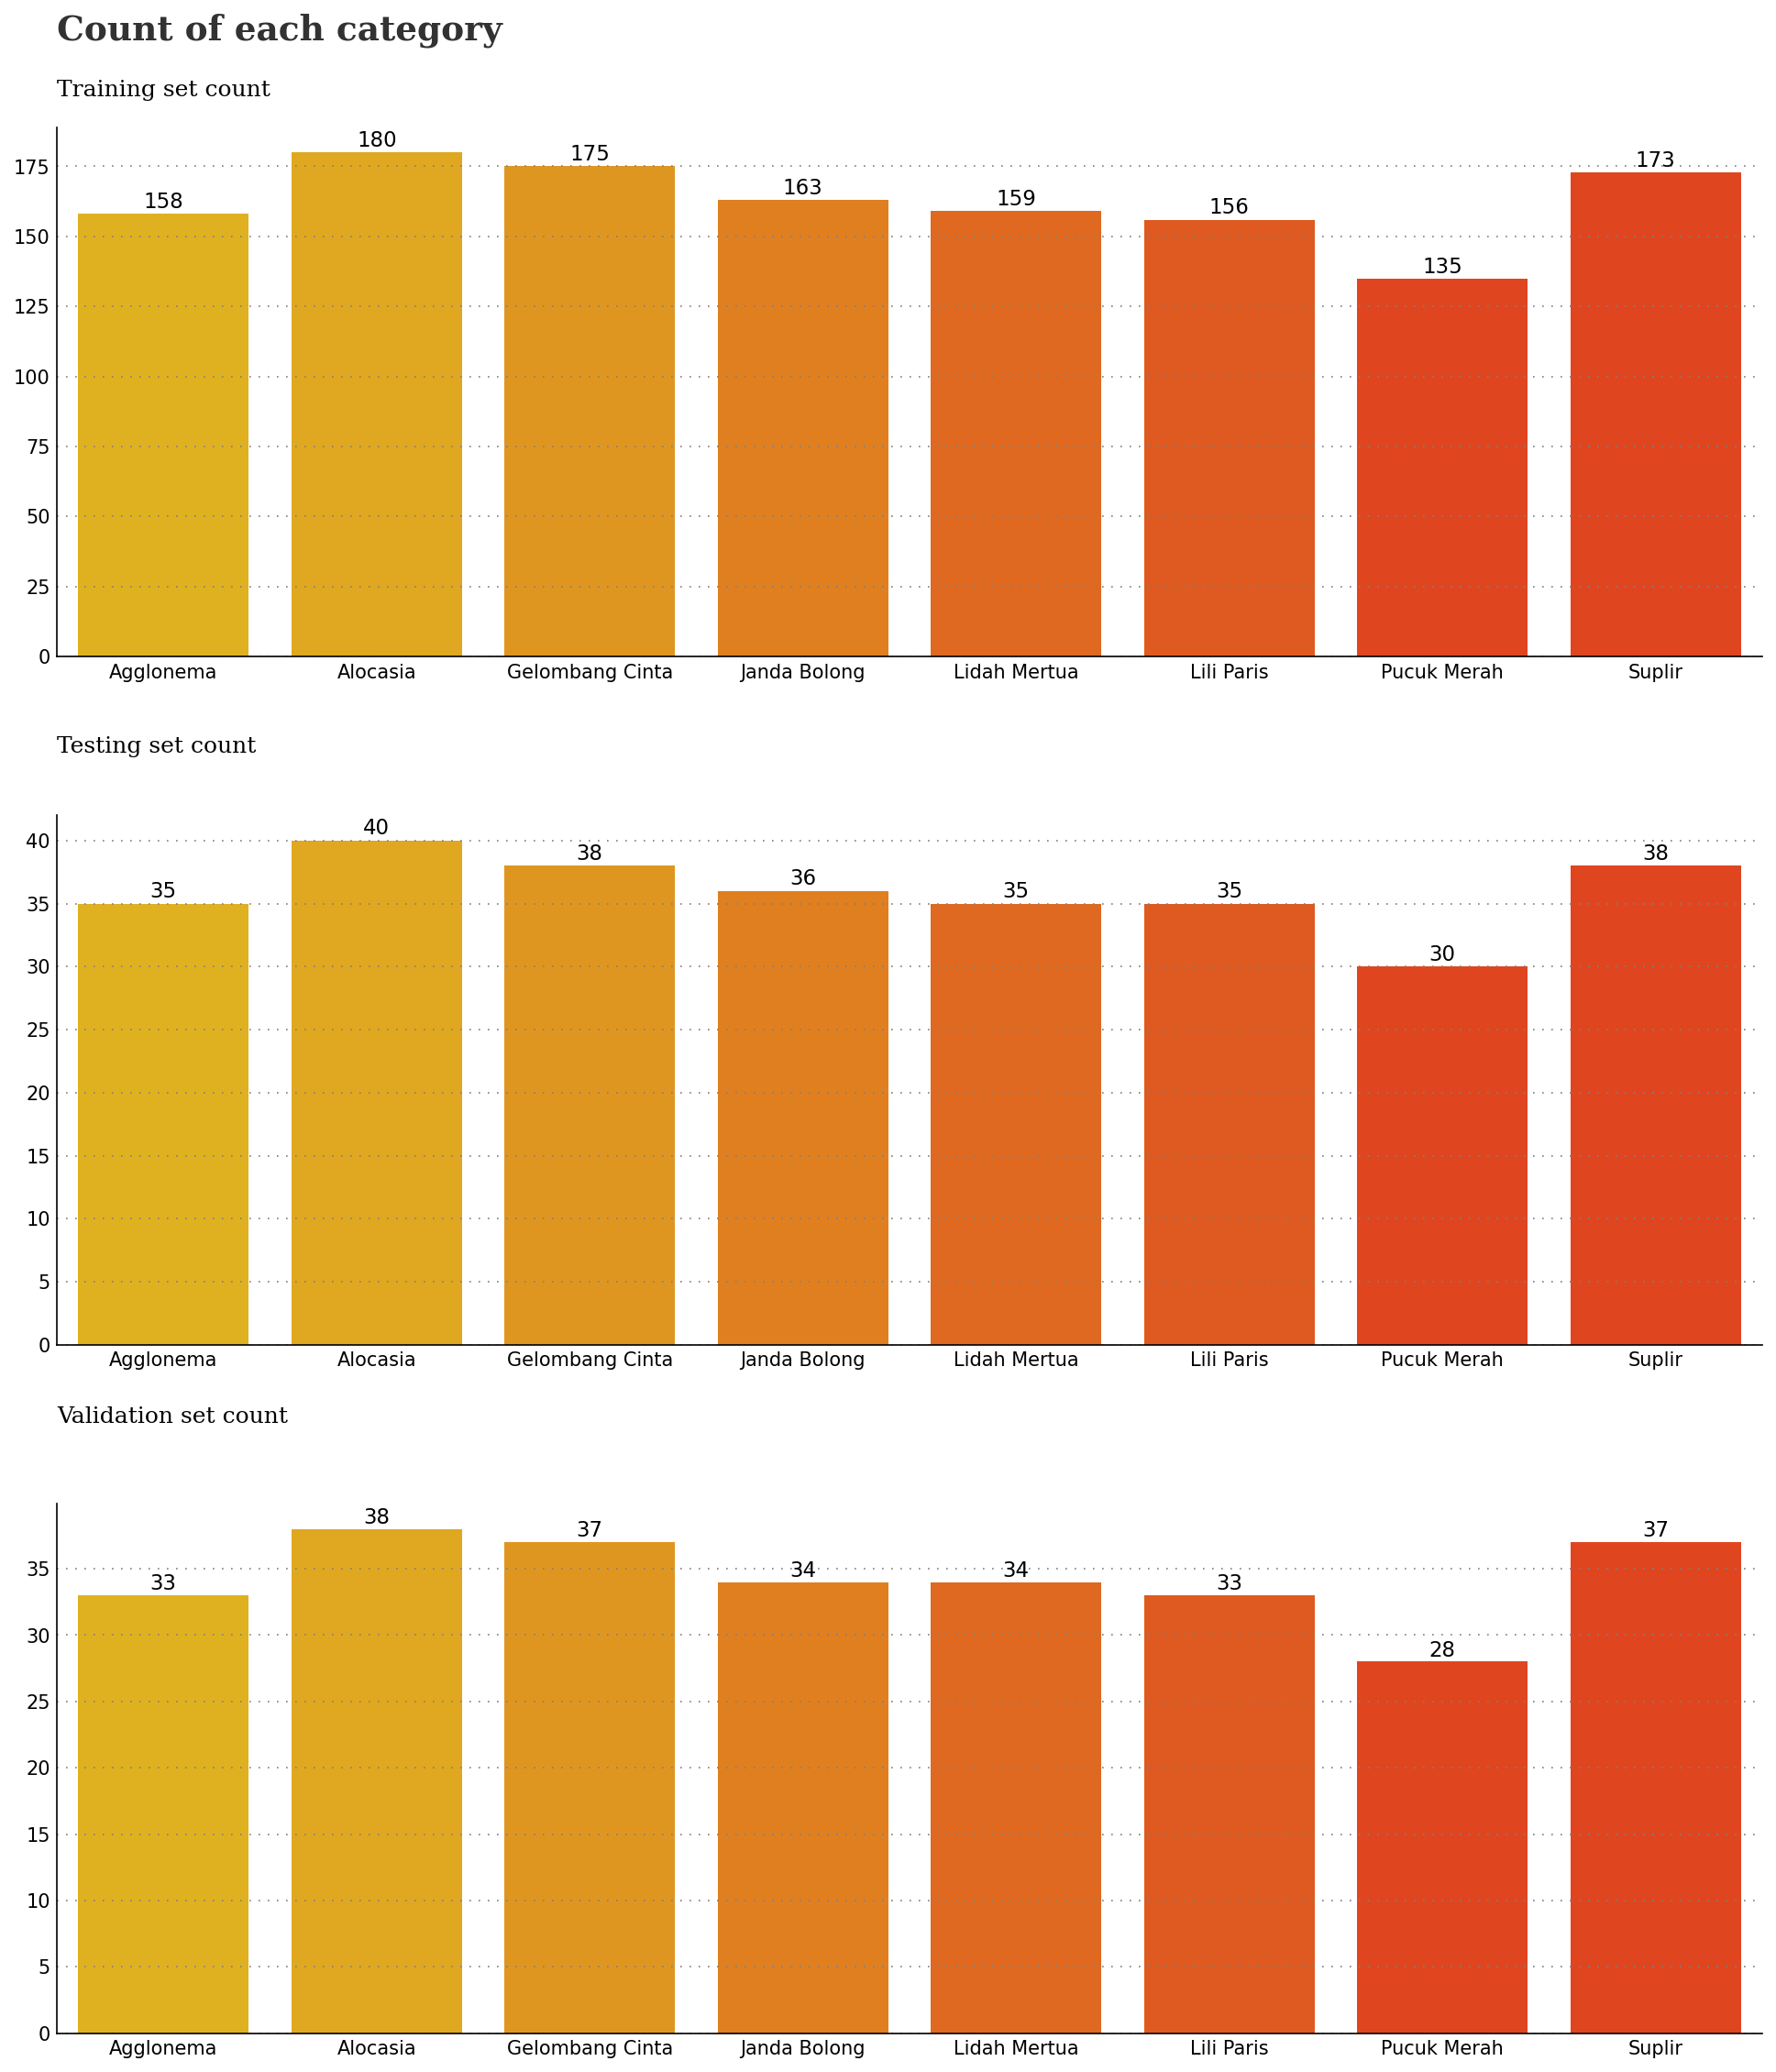

In [59]:
custom_palette = ['#ffc100','#ffb600','#ff9e00','#ff7f00','#ff6100','#ff4d00','#ff3300','#ff3300']
sns.set_palette(custom_palette)


fig = plt.figure(figsize=(16, 18), dpi=150)

gs = fig.add_gridspec(3, 1)
gs.update(wspace=0.4, hspace=0.3)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])

#AX0 - Data Train
ax0.text(-0.5, 220, 'Count of each category', fontsize=18,
         fontweight='bold', fontfamily='serif', color="#323232")
ax0.text(-0.5, 200, 'Training set count',
         fontfamily='serif', fontsize=12, fontweight='light')
sns.barplot(x=class_names,y=trainCount, ax=ax0)
for i in range(8):
    ax0.annotate(f'{trainCount[i]}', 
                    xy =(i, trainCount[i]+2),
                    color='black',
                    horizontalalignment='center',
                    fontsize=11,
                    fontweight='light'
                    )

#AX1 - Data Test
ax1.text(-0.5, 47, 'Testing set count',
         fontfamily='serif', fontsize=12, fontweight='light')
sns.barplot(x=class_names,y=testCount, ax=ax1)
for i in range(8):
    ax1.annotate(f'{testCount[i]}', 
                    xy =(i, testCount[i]+0.5),
                    color='black',
                    horizontalalignment='center',
                    fontsize=11,
                    fontweight='light'
                    )



ax2.text(-0.5, 46, 'Validation set count',
         fontfamily='serif', fontsize=12, fontweight='light')
sns.barplot(x=class_names,y=valCount, ax=ax2)
for i in range(8):
    ax2.annotate(f'{valCount[i]}', 
                    xy =(i, valCount[i]+0.4),
                    color='black',
                    horizontalalignment='center',
                    fontsize=11,
                    fontweight='light'
                    )

for s in ["top", "right"]:
    for i in range(0, 3):
        locals()["ax"+str(i)].spines[s].set_visible(False)

for i in range(0, 3):
    locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both', length=0)
    locals()["ax"+str(i)].grid(color='gray', linestyle=':',
                               axis='y', zorder=0,  dashes=(1, 5))

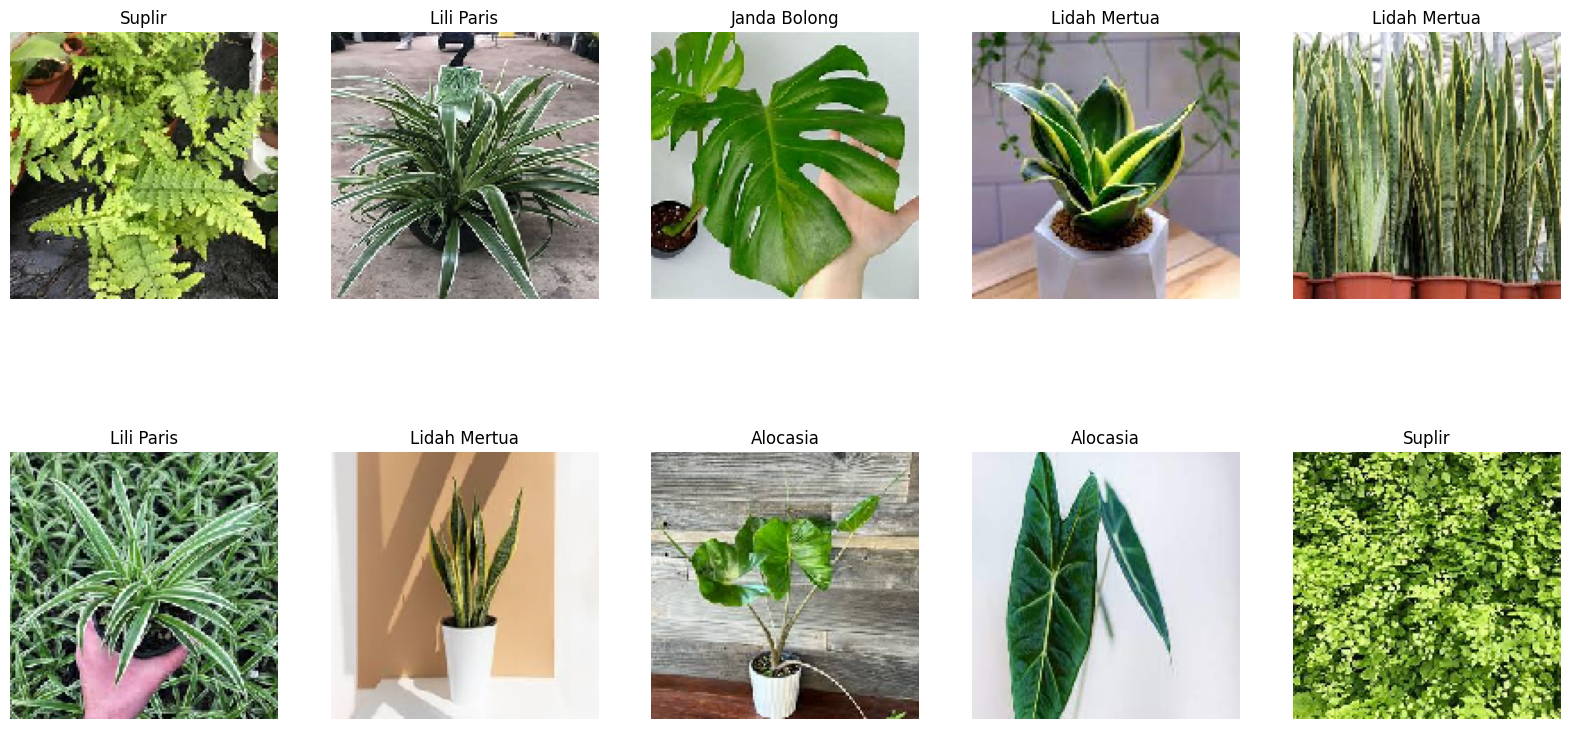

In [60]:
image ,label = next(iter(test_generator))

plt.figure(figsize=(20,10))
for i in range(10) :
  plt.subplot(2,5,i+1)
  plt.imshow(image[i])
  plt.title(class_names[np.argmax(label[i])])
  plt.axis("off")

### Modelling

**Callbacks**

In [61]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                       factor=0.4, patience=3, 
                                       verbose=1, mode='min', 
                                       min_delta=0.0001, min_lr=0,
                                       restore_best_weights=True)

#### EfficientNet

In [62]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from efficientnet.tfkeras import EfficientNetB3

**EfficientNetB3**

In [63]:
pre_trained_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
    pooling='avg',
)

In [64]:
for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('avg_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x) # change the activation to relu
x = layers.Dense(1024, activation='relu')(x) #
# change the dropout from 0.2 to 0.3
x = layers.Dropout(0.3)(x)                  
x = layers.Dense(8, activation='softmax')(x)           

model_B3 = Model( pre_trained_model.input, x) 

model_B3.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [65]:
history_b3 = model_B3.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 25,
            verbose = 1,
            callbacks=[reduceLROnPlat])

Epoch 1/25
41/41 [==============================] - 184s 4s/step - loss: 1.2156 - accuracy: 0.5574 - val_loss: 0.7456 - val_accuracy: 0.7664 - lr: 0.0010
Epoch 2/25
41/41 [==============================] - 153s 4s/step - loss: 0.6295 - accuracy: 0.7914 - val_loss: 0.6765 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 3/25
41/41 [==============================] - 149s 4s/step - loss: 0.5085 - accuracy: 0.8276 - val_loss: 0.5581 - val_accuracy: 0.8248 - lr: 0.0010
Epoch 4/25
41/41 [==============================] - 148s 4s/step - loss: 0.4113 - accuracy: 0.8653 - val_loss: 0.5335 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 5/25
41/41 [==============================] - 147s 4s/step - loss: 0.3395 - accuracy: 0.8845 - val_loss: 0.5510 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 6/25
41/41 [==============================] - 147s 4s/step - loss: 0.3115 - accuracy: 0.8953 - val_loss: 0.6235 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 7/25
41/41 [==============================] - ETA: 0s - loss: 0.3086 -

In [66]:
B3_eval = model_B3.evaluate(test_generator)
print("======== EfficientNetB3 ===============")
print(f'Test loss     : {B3_eval[0]}')
print(f'Test accuracy : {round(B3_eval[1],2)}')

9/9 [==============================] - 27s 3s/step - loss: 0.3506 - accuracy: 0.8815
======== EfficientNetB3 ===============
Test loss     : 0.35058829188346863
Test accuracy : 0.88


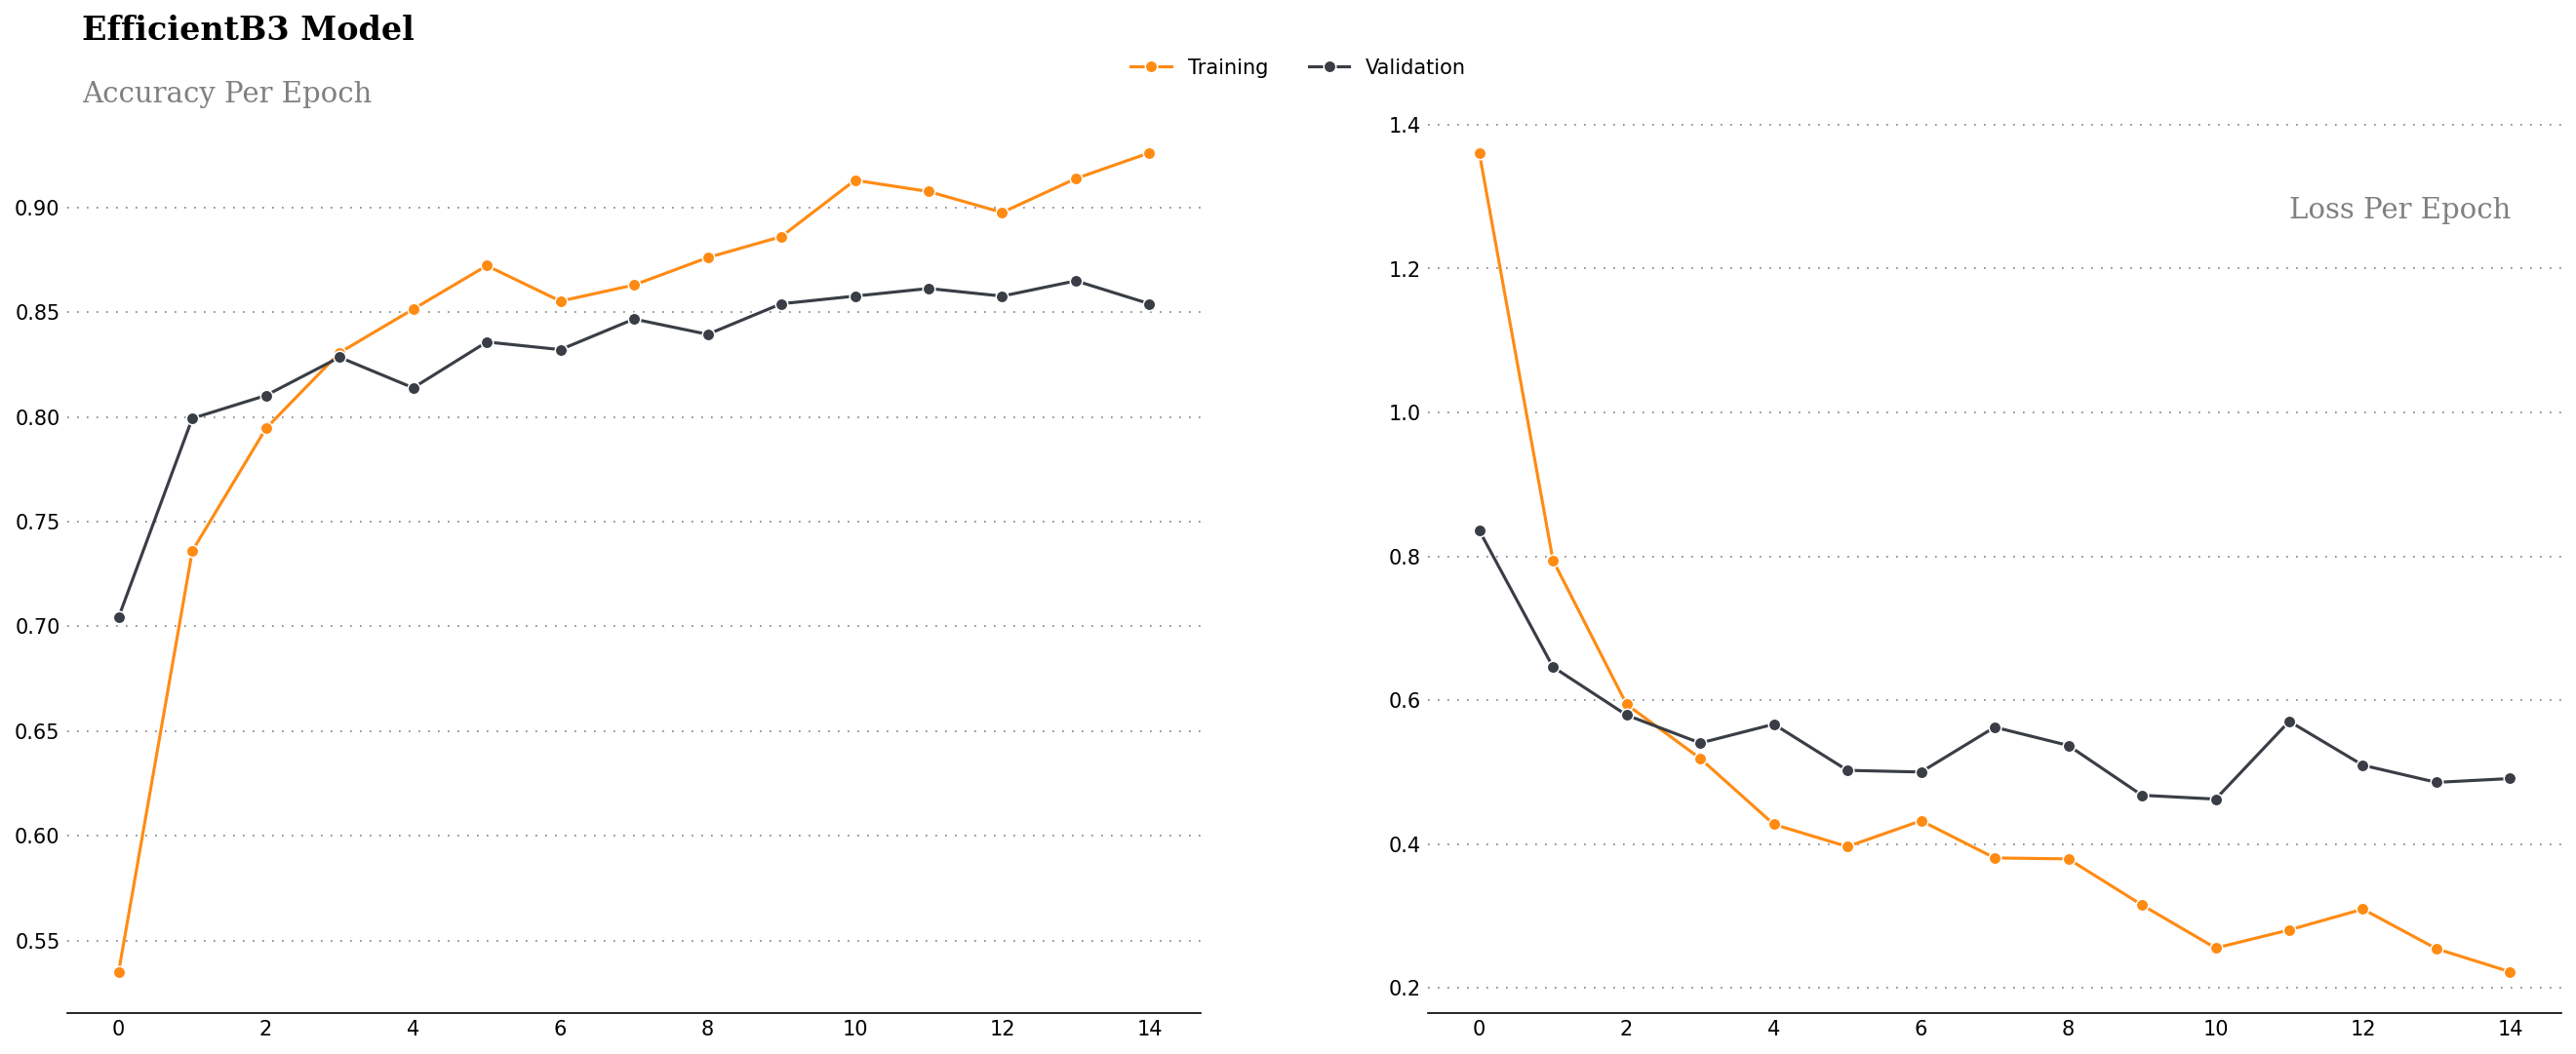

In [17]:
fig = plt.figure(figsize=(22,8), dpi=150)

palette = ["#FF8B13","#393E46"]

#Acquaire history from EfficientNetB3
len_B3 = len(history_b3.history['accuracy'])
accuracy_B3 = history_b3.history['accuracy']
val_accuracy_B3 = history_b3.history['val_accuracy']

loss_B3 = history_b3.history['loss']
val_loss_B3 = history_b3.history['val_loss']

gs = fig.add_gridspec(1, 2)
gs.update(hspace=0.3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

#Lineplot Accuracy
ax0.text(-0.5, 0.98,"EfficientB3 Model",fontsize=16, fontweight='bold',fontfamily='serif')
ax0.text(-0.5, 0.95,"Accuracy Per Epoch",fontsize=14, fontweight='light',color='gray',fontfamily='serif')
ax0_x_ticks = np.arange(0, len_B3)
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.lineplot(x=ax0_x_ticks,y=accuracy_B3,ax=ax0,label='Training',color=palette[0],marker='o')
sns.lineplot(x=ax0_x_ticks,y=val_accuracy_B3,ax=ax0,label='Validation',color=palette[1],marker='o')

legend_labels, _= ax0.get_legend_handles_labels()
ax0.legend(legend_labels, ["Training", "Validation"], ncol=2, bbox_to_anchor=(1.25, 1.08), edgecolor='white')

#Lineplot Loss
ax1.text(11, 1.27,"Loss Per Epoch",fontsize=14, fontweight='light',color='gray',fontfamily='serif')
ax1_x_ticks = np.arange(0, len_B3)
ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.lineplot(x=ax0_x_ticks,y=loss_B3,ax=ax1,label='Training',color=palette[0],marker='o')
sns.lineplot(x=ax0_x_ticks,y=val_loss_B3,ax=ax1,label='Validation',color=palette[1],marker='o')
ax1.get_legend().remove()

for s in ["top","right","left"]:
    for i in range(0,2):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)

In [18]:
#Save model
model_B3.save('Saved_Models/model_EfficientNetB3.h5')

**EfficientNetB7**

In [20]:
from efficientnet.tfkeras import EfficientNetB7

pre_trained_model = EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
    pooling='avg',
)

In [21]:
for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('avg_pool')
last_output = last_layer.output


x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)              
x = layers.Dense (8, activation='softmax')(x)           

model_B7 = Model( pre_trained_model.input, x) 

model_B7.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [22]:
history = model_B7.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 15,
            callbacks=[reduceLROnPlat],
            verbose = 1)
            

Epoch 1/15
21/21 [==============================] - 475s 21s/step - loss: 1.5448 - accuracy: 0.4411 - val_loss: 1.1716 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - 428s 20s/step - loss: 1.1045 - accuracy: 0.6197 - val_loss: 0.8440 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - 425s 20s/step - loss: 0.9278 - accuracy: 0.6851 - val_loss: 0.8243 - val_accuracy: 0.7372 - lr: 0.0010
Epoch 4/15
21/21 [==============================] - 433s 21s/step - loss: 0.8000 - accuracy: 0.7198 - val_loss: 0.7310 - val_accuracy: 0.7591 - lr: 0.0010
Epoch 5/15
21/21 [==============================] - 425s 20s/step - loss: 0.7295 - accuracy: 0.7467 - val_loss: 0.7665 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 6/15
21/21 [==============================] - 422s 20s/step - loss: 0.6954 - accuracy: 0.7691 - val_loss: 0.7811 - val_accuracy: 0.7701 - lr: 0.0010
Epoch 7/15
21/21 [==============================] - ETA: 0s - loss: 0.

In [23]:
B7_eval = model_B7.evaluate(test_generator)
print("======== EfficientNetB7 ===============")
print(f'Test loss     : {B7_eval[0]}')
print(f'Test accuracy : {round(B7_eval[1],2)}')

5/5 [==============================] - 86s 17s/step - loss: 0.4326 - accuracy: 0.8571
======== EfficientNetB7 ===============
Test loss     : 0.43257635831832886
Test accuracy : 0.86
